# Part 4: Apply hypothesis testing to explore what makes a movie successful.

For part 4 of the project, you will be using your MySQL database from part 3 to answer meaningful questions for your stakeholder. They want you to use your hypothesis testing and statistics knowledge to answer 3 questions about what makes a successful movie.

### The Data

In Phase 2, as a proof-of-concept, the stakeholder requested a test extraction of movies that started in 2000 or 2001. Each year to be saved as a separate .csv.gz file.

In Phase 4, the stakeholder has requested additional years to be extracted. Years 2012-2022 are to be combined into a single TMDB .csv.gz file.

## Import Libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter
price_fmt = StrMethodFormatter("${x:,.0f}")
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Additional Imports
import os, json, math, time
import tmdbsimple as tmdb
from tqdm.notebook import tqdm_notebook
import glob
import pymysql
pymysql.install_as_MySQLdb()
from sqlalchemy.types import *
from sqlalchemy_utils import create_database, database_exists
from sqlalchemy import create_engine
from scipy import stats
## Post Hoc
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

## TBDB API Credentials

In [70]:
import json
with open('/Users/parri_nqdmzn3/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()

dict_keys(['api-key'])

In [71]:
tmdb.API_KEY =  login['api-key']

## Load Data

In [72]:
# Load the dataframe from the csv file
basics = pd.read_csv('Data/title_basics.csv.gz')
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama
...,...,...,...,...,...,...,...,...,...
81864,tt9914942,movie,Life Without Sara Amat,La vida sense la Sara Amat,0,2019.0,NaN,74,Drama
81865,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019.0,NaN,97,"Comedy,Drama,Fantasy"
81866,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
81867,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"


### Test the API Call

In [73]:
# Make a movie object using the .Movies function from tmdb
movie = tmdb.Movies(603)

In [74]:
# Display the .info dictionary of the movie object
info = movie.info()
info

{'adult': False,
 'backdrop_path': '/oMsxZEvz9a708d49b6UdZK1KAo5.jpg',
 'belongs_to_collection': {'id': 2344,
  'name': 'The Matrix Collection',
  'poster_path': '/bV9qTVHTVf0gkW0j7p7M0ILD4pG.jpg',
  'backdrop_path': '/bRm2DEgUiYciDw3myHuYFInD7la.jpg'},
 'budget': 63000000,
 'genres': [{'id': 28, 'name': 'Action'},
  {'id': 878, 'name': 'Science Fiction'}],
 'homepage': 'http://www.warnerbros.com/matrix',
 'id': 603,
 'imdb_id': 'tt0133093',
 'original_language': 'en',
 'original_title': 'The Matrix',
 'overview': 'Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.',
 'popularity': 80.68,
 'poster_path': '/f89U3ADr1oiB1s9GkdPOEpXUk5H.jpg',
 'production_companies': [{'id': 79,
   'logo_path': '/tpFpsqbleCzEE2p5EgvUq6ozfCA.png',
   'name': 'Village Roadshow Pictures',
   'origin_country': 'US'},
  {'id': 372,
   'logo_path': None,
   'name': 'Groucho II Film 

### Designate Folder to save results

In [75]:
FOLDER = 'Data/'
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2010.csv.gz',
 'final_tmdb_data_2018.csv.gz',
 'final_tmdb_data_2019.csv.gz',
 'final_tmdb_data_2020.csv.gz',
 'final_tmdb_data_2022.csv.gz',
 'title_akas.csv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz',
 'tmbd_results_combined.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_2011.json',
 'tmdb_api_results_2013.json',
 'tmdb_api_results_2017.json',
 'tmdb_api_results_2018.json',
 'tmdb_api_results_2019.json',
 'tmdb_api_results_2020.json',
 'tmdb_api_results_2022.json']

## Custom Functions

### Adding the certification/rating to movie.info

In [77]:
# Function to obtain movie rating
def get_movie_with_rating(movie_id):
    # Get movie and release dates
    movie = tmdb.Movies(movie_id)
    # Construct output dictionary
    movie_info = movie.info()
    releases = movie.releases()
    for c in releases['countries']:
        if c['iso_3166_1'] == 'US':
            movie_info['certification'] = c['certification']
    return movie_info

### Append/extend a JSON file

In [140]:
# Append new results to the existing JSON file
# Adapted from: 
# https://www.geeksforgeeks.org/append-to-json-file-using-python/   

def write_json(new_data, filename): 
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [141]:
# Create a function to evaluate the p=value of a hypothesis test
def interpret_pvalue(ho, ha, alpha=.05):
    ho_desc = 'No statistical significance exists. The null hypothesis was not rejected.'
    ha_desc = 'A statistical significance exists. The null hypothesis is rejected and the alternative is supported that..'
    if pvalue < alpha:
        print(f'The p-value for the test was {pvalue}')
        print(f'It was < the alpha value of {alpha}, so')
        print(ha_desc)
        print(ha)
    else:
        print(f'The p-value for the test was {pvalue}')
        print(f'It was > the alpha value of {alpha}, so')
        print(ho_desc)
        print(ho)

## Designate Folder to save results

In [81]:
FOLDER = 'Data/'
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2010.csv.gz',
 'final_tmdb_data_2018.csv.gz',
 'final_tmdb_data_2019.csv.gz',
 'final_tmdb_data_2020.csv.gz',
 'final_tmdb_data_2022.csv.gz',
 'title_akas.csv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz',
 'tmbd_results_combined.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_2011.json',
 'tmdb_api_results_2013.json',
 'tmdb_api_results_2017.json',
 'tmdb_api_results_2018.json',
 'tmdb_api_results_2019.json',
 'tmdb_api_results_2020.json',
 'tmdb_api_results_2022.json']

### Confirm API function works

In [83]:
test1 = get_movie_with_rating("tt0848228") #put your function name here
test1

{'adult': False,
 'backdrop_path': '/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg',
 'belongs_to_collection': {'id': 86311,
  'name': 'The Avengers Collection',
  'poster_path': '/yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg',
  'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
 'budget': 220000000,
 'genres': [{'id': 878, 'name': 'Science Fiction'},
  {'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'https://www.marvel.com/movies/the-avengers',
 'id': 24428,
 'imdb_id': 'tt0848228',
 'original_language': 'en',
 'original_title': 'The Avengers',
 'overview': 'When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!',
 'popularity': 123.37,
 'poster_path': '/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg',
 'production_companies': [{'id': 420,
   'logo_path'

## Object for Year Range to Retrieve

In [84]:
YEARS_TO_GET = range(2012, 2023)
errors = []

In [85]:
"""From Coding Dojo Learning Platform"""
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'

    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)

    #Saving new year as the current df
    #Filter for basics df for only specific year
    df = basics[basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    
    ###Stop gap measure to insure previously retrieved data isn't retrieved again
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)

    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]

#############################################################################
    #Get index and movie id from list
    # INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve the data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)

        except Exception as e:
            errors.append([movie_id, e])
#############################################################################        
    
    #save file as .csv.gz  
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", 
                         compression="gzip", index=False)

# print number of errors
print(f"- Total errors: {len(errors)}")

YEARS:   0%|          | 0/11 [00:00<?, ?it/s]

Movies from 2012:   0%|          | 0/4522 [00:00<?, ?it/s]

Movies from 2013:   0%|          | 0/4675 [00:00<?, ?it/s]

Movies from 2014:   0%|          | 0/4917 [00:00<?, ?it/s]

Movies from 2015:   0%|          | 0/5056 [00:00<?, ?it/s]

Movies from 2016:   0%|          | 0/5254 [00:00<?, ?it/s]

Movies from 2017:   0%|          | 0/4279 [00:00<?, ?it/s]

Movies from 2018:   0%|          | 0/1104 [00:00<?, ?it/s]

Movies from 2019:   0%|          | 0/978 [00:00<?, ?it/s]

Movies from 2020:   0%|          | 0/1047 [00:00<?, ?it/s]

Movies from 2021:   0%|          | 0/5159 [00:00<?, ?it/s]

Movies from 2022: 0it [00:00, ?it/s]

- Total errors: 11366


## Using Glob to Combine Files

In [231]:
q = "Data/*final_tmdb_data_*.csv.gz"
chunked_files = glob.glob(q)
# Showing the first 10
files_to_get = chunked_files[10:]
files_to_get

['Data\\final_tmdb_data_2019.csv.gz',
 'Data\\final_tmdb_data_2020.csv.gz',
 'Data\\final_tmdb_data_2021.csv.gz',
 'Data\\final_tmdb_data_2022.csv.gz']

In [232]:
## Loading all files as df and appending to a list
df_list = []
for file in files_to_get:
    temp_df = pd.read_csv(file, index_col=0)
    df_list.append(temp_df)
    
## Concatenating the list of dfs into 1 combined
df_combined = pd.concat(df_list)
df_combined

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0385887,0.0,/xMHeU84wLQ9uH9acJ0oPgdii9wO.jpg,NaN,26000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",https://www.motherlessbrooklynfilm.com,504562.0,en,Motherless Brooklyn,"New York City, 1957. Lionel Essrog, a private ...",17.088,/jjMJy5OxJHpFIaboCklDIYdcfpD.jpg,"[{'id': 2297, 'logo_path': None, 'name': 'Clas...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-10-31,18377736.0,145.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Motherless Brooklyn,0.0,6.722,1285.0,R
tt0437086,0.0,/8RKBHHRqOMOLh5qW3sS6TSFTd8h.jpg,NaN,170000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",https://family.20thcenturystudios.com/movies/a...,399579.0,en,Alita: Battle Angel,When Alita awakens with no memory of who she i...,59.132,/xRWht48C2V8XNfzvPehyClOvDni.jpg,"[{'id': 10807, 'logo_path': '/j0BcMaJKIiDDYHq9...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-01-31,404980543.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,An angel falls. A warrior rises.,Alita: Battle Angel,0.0,7.217,8316.0,PG-13
tt0441881,0.0,/7uacpbrJd9g9xSTLgfyg1NwkAiu.jpg,NaN,23934823.0,"[{'id': 10752, 'name': 'War'}, {'id': 28, 'nam...",http://dangerclosemovie.com,508664.0,en,Danger Close: The Battle of Long Tan,"Vietnam War, 1966. Australia and New Zealand s...",19.663,/aB1rCWGMsM2mm1kBDleaPkqUCFo.jpg,"[{'id': 101576, 'logo_path': None, 'name': 'Re...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...",2019-08-08,2078370.0,119.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Outnumbered. Outgunned. Never out of courage,Danger Close: The Battle of Long Tan,0.0,6.872,270.0,R
tt0448115,0.0,/o7JVhqMmrex1TPbmuxl8YXVlcfl.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",80000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",http://www.shazammovie.com,287947.0,en,Shazam!,A boy is given the ability to become an adult ...,62.795,/xnopI5Xtky18MPhK40cZAGAOVeV.jpg,"[{'id': 12, 'logo_path': '/5ThIuO93vsk47oexKTS...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-03-29,366080049.0,132.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Just say the word.,Shazam!,0.0,7.000,8697.0,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9896876,0.0,/hMvRbT6HOqERhh3K8kXbaLz9LlZ.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,821493.0,en,India Sweets and Spices,A college freshman confronts her parents’ valu...,3.074,/2cUczTzLq1F99Pgiw6BWFsKnD7J.jpg,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...","[{'iso_3166_1': 'US', 'name': 'United States o...",2021-11-19,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Let the aunties talk.,India Sweets and Spices,0.0,6.100,10.0,PG-13
tt9898844,0.0,/q2KFBGyUSzHDhNqXEYv2LqTWVSz.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,870671.0,en,The Hunting,When a mysterious animal attack leaves a mutil...,15.557,/kvhrltQIRp1u84ao9uj52YPaWNY.jpg,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...","[{'iso_3166_1': 'US', 'name': 'United States o...",2022-01-21,0.0,91.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Hunger runs deep.,The Hunting,0.0,4.700,34.0,NaN
tt9900940,0.0,/3jjWLg5bevWqReyVroYqxwVrH0k.jpg,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,861294.0,en,The Scrapper,"Ex-con turned ""scrapper"" Jake leads a quiet li...",6.165,/ydnOAvlBzdqMyBRBXyQpReSzxrH.jpg,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...","[{'iso_3166_1': 'US', 'name': 'United States o...",2021-12-07,0.0,87.0,"[{'

In [233]:
df_combined.drop(index=0, inplace=True)
df_combined.drop(index='0', inplace=True)
df_combined

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,
tt0385887,0.0,/xMHeU84wLQ9uH9acJ0oPgdii9wO.jpg,NaN,26000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",https://www.motherlessbrooklynfilm.com,504562.0,en,Motherless Brooklyn,"New York City, 1957. Lionel Essrog, a private ...",17.088,/jjMJy5OxJHpFIaboCklDIYdcfpD.jpg,"[{'id': 2297, 'logo_path': None, 'name': 'Clas...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-10-31,18377736.0,145.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Motherless Brooklyn,0.0,6.722,1285.0,R
tt0437086,0.0,/8RKBHHRqOMOLh5qW3sS6TSFTd8h.jpg,NaN,170000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",https://family.20thcenturystudios.com/movies/a...,399579.0,en,Alita: Battle Angel,When Alita awakens with no memory of who she i...,59.132,/xRWht48C2V8XNfzvPehyClOvDni.jpg,"[{'id': 10807, 'logo_path': '/j0BcMaJKIiDDYHq9...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-01-31,404980543.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,An angel falls. A warrior rises.,Alita: Battle Angel,0.0,7.217,8316.0,PG-13
tt0441881,0.0,/7uacpbrJd9g9xSTLgfyg1NwkAiu.jpg,NaN,23934823.0,"[{'id': 10752, 'name': 'War'}, {'id': 28, 'nam...",http://dangerclosemovie.com,508664.0,en,Danger Close: The Battle of Long Tan,"Vietnam War, 1966. Australia and New Zealand s...",19.663,/aB1rCWGMsM2mm1kBDleaPkqUCFo.jpg,"[{'id': 101576, 'logo_path': None, 'name': 'Re...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...",2019-08-08,2078370.0,119.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Outnumbered. Outgunned. Never out of courage,Danger Close: The Battle of Long Tan,0.0,6.872,270.0,R
tt0448115,0.0,/o7JVhqMmrex1TPbmuxl8YXVlcfl.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",80000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",http://www.shazammovie.com,287947.0,en,Shazam!,A boy is given the ability to become an adult ...,62.795,/xnopI5Xtky18MPhK40cZAGAOVeV.jpg,"[{'id': 12, 'logo_path': '/5ThIuO93vsk47oexKTS...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-03-29,366080049.0,132.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Just say the word.,Shazam!,0.0,7.000,8697.0,PG-13
tt0783640,0.0,/eZwwJ5yRpMDhZzfMS7XeWwUzLSE.jpg,NaN,20000000.0,"[{'id': 10752, 'name': 'War'}, {'id': 18, 'nam...",https://www.thelastfullmeasurefilm.com/,442065.0,en,The Last Full Measure,The incredible true story of Vietnam War hero ...,14.652,/bMG8c80lyEkBXVgyHVqsdQhjgf6.jpg,"[{'id': 21897, 'logo_path': None, 'name': 'For...","[{'iso_3166_1': 'US', 'name': 'United States o...",2020-01-23,3364426.0,110.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate sacrifice deserves the highest ho...,The Last Full Measure,0.0,7.472,394.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9895024,0.0,/S1kutYyoyuBJKGS0mXxv2fZNbr.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,834443.0,de,Heikos Welt,A son tries to save his mother's eyesight by d...,1.590,/u2rxIUdUoCkm8gDfYPnFEHS4OLp.jpg,"[{'id': 154995, 'logo_path': None, 'name': 'AS...","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",2021-09-08,0.0,118.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Heiko's World,0.0,6.375,4.0,NaN
tt9896876,0.0,/hMvRbT6HOqERhh3K8kXbaLz9LlZ.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,821493.0,en,India Sweets and Spices,A college freshman confronts her parents’ valu...,3.074,/2cUczTzLq1F99Pgiw6BWFsKnD7J.jpg,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...","[{'iso_3166_1': 'US', 'name': 'United States o...",2021-11-19,0.0,101.0,"[{'english_name': 'English', 

## Clean Groups
- Will change/combine:
 - '10' = 'G'
 - 'PG-13 ' (has extra space) = 'PG-13'
 - 'Unrated' = 'NR'

In [234]:
df_combined['certification'].value_counts()

R        846
NR       755
PG-13    431
PG       238
G         69
NC-17     30
Name: certification, dtype: int64

In [235]:
df_combined['certification'] = df_combined['certification'].str.replace('10', 'PG')
df_combined['certification'] = df_combined['certification'].str.replace('PG-13 ', 'PG-13')
df_combined['certification'] = df_combined['certification'].str.replace('Unrated', 'NR')
df_combined['certification'].value_counts()

R        846
NR       755
PG-13    431
PG       238
G         69
NC-17     30
Name: certification, dtype: int64

## TMDB csv file

In [236]:
## Saving the final combined dataframe
final_fname ='Data/final_combined.csv.gz'
df_combined.to_csv(final_fname, compression='gzip', index=False)

In [237]:
df_combined = pd.read_csv(final_fname)
df_combined.head(3)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0.0,/xMHeU84wLQ9uH9acJ0oPgdii9wO.jpg,NaN,26000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",https://www.motherlessbrooklynfilm.com,504562.0,en,Motherless Brooklyn,"New York City, 1957. Lionel Essrog, a private ...",17.088,/jjMJy5OxJHpFIaboCklDIYdcfpD.jpg,"[{'id': 2297, 'logo_path': None, 'name': 'Clas...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-10-31,18377736.0,145.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Motherless Brooklyn,0.0,6.722,1285.0,R
1,0.0,/8RKBHHRqOMOLh5qW3sS6TSFTd8h.jpg,NaN,170000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",https://family.20thcenturystudios.com/movies/a...,399579.0,en,Alita: Battle Angel,When Alita awakens with no memory of who she i...,59.132,/xRWht48C2V8XNfzvPehyClOvDni.jpg,"[{'id': 10807, 'logo_path': '/j0BcMaJKIiDDYHq9...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-01-31,404980543.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,An angel falls. A warrior rises.,Alita: Battle Angel,0.0,7.217,8316.0,PG-13
2,0.0,/7uacpbrJd9g9xSTLgfyg1NwkAiu.jpg,NaN,23934823.0,"[{'id': 10752, 'name': 'War'}, {'id': 28, 'nam...",http://dangerclosemovie.com,508664.0,en,Danger Close: The Battle of Long Tan,"Vietnam War, 1966. Australia and New Zealand s...",19.663,/aB1rCWGMsM2mm1kBDleaPkqUCFo.jpg,"[{'id': 101576, 'logo_path': None, 'name': 'Re...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...",2019-08-08,2078370.0,119.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Outnumbered. Outgunned. Never out of courage,Danger Close: The Battle of Long Tan,0.0,6.872,270.0,R


In [238]:
print(df_combined.index)

RangeIndex(start=0, stop=12886, step=1)


In [239]:
#df_combined.drop(index=0, inplace=True)

df_combined.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0.0,/xMHeU84wLQ9uH9acJ0oPgdii9wO.jpg,NaN,26000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",https://www.motherlessbrooklynfilm.com,504562.0,en,Motherless Brooklyn,"New York City, 1957. Lionel Essrog, a private ...",17.088,/jjMJy5OxJHpFIaboCklDIYdcfpD.jpg,"[{'id': 2297, 'logo_path': None, 'name': 'Clas...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-10-31,18377736.0,145.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Motherless Brooklyn,0.0,6.722,1285.0,R
1,0.0,/8RKBHHRqOMOLh5qW3sS6TSFTd8h.jpg,NaN,170000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",https://family.20thcenturystudios.com/movies/a...,399579.0,en,Alita: Battle Angel,When Alita awakens with no memory of who she i...,59.132,/xRWht48C2V8XNfzvPehyClOvDni.jpg,"[{'id': 10807, 'logo_path': '/j0BcMaJKIiDDYHq9...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-01-31,404980543.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,An angel falls. A warrior rises.,Alita: Battle Angel,0.0,7.217,8316.0,PG-13
2,0.0,/7uacpbrJd9g9xSTLgfyg1NwkAiu.jpg,NaN,23934823.0,"[{'id': 10752, 'name': 'War'}, {'id': 28, 'nam...",http://dangerclosemovie.com,508664.0,en,Danger Close: The Battle of Long Tan,"Vietnam War, 1966. Australia and New Zealand s...",19.663,/aB1rCWGMsM2mm1kBDleaPkqUCFo.jpg,"[{'id': 101576, 'logo_path': None, 'name': 'Re...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...",2019-08-08,2078370.0,119.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Outnumbered. Outgunned. Never out of courage,Danger Close: The Battle of Long Tan,0.0,6.872,270.0,R
3,0.0,/o7JVhqMmrex1TPbmuxl8YXVlcfl.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",80000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",http://www.shazammovie.com,287947.0,en,Shazam!,A boy is given the ability to become an adult ...,62.795,/xnopI5Xtky18MPhK40cZAGAOVeV.jpg,"[{'id': 12, 'logo_path': '/5ThIuO93vsk47oexKTS...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-03-29,366080049.0,132.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Just say the word.,Shazam!,0.0,7.000,8697.0,PG-13
4,0.0,/eZwwJ5yRpMDhZzfMS7XeWwUzLSE.jpg,NaN,20000000.0,"[{'id': 10752, 'name': 'War'}, {'id': 18, 'nam...",https://www.thelastfullmeasurefilm.com/,442065.0,en,The Last Full Measure,The incredible true story of Vietnam War hero ...,14.652,/bMG8c80lyEkBXVgyHVqsdQhjgf6.jpg,"[{'id': 21897, 'logo_path': None, 'name': 'For...","[{'iso_3166_1': 'US', 'name': 'United States o...",2020-01-23,3364426.0,110.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate sacrifice deserves the highest ho...,The Last Full Measure,0.0,7.472,394.0,R


In [240]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12886 entries, 0 to 12885
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  12886 non-null  float64
 1   backdrop_path          10027 non-null  object 
 2   belongs_to_collection  733 non-null    object 
 3   budget                 12886 non-null  float64
 4   genres                 12886 non-null  object 
 5   homepage               3527 non-null   object 
 6   id                     12886 non-null  float64
 7   original_language      12886 non-null  object 
 8   original_title         12886 non-null  object 
 9   overview               12686 non-null  object 
 10  popularity             12886 non-null  float64
 11  poster_path            12641 non-null  object 
 12  production_companies   12886 non-null  object 
 13  production_countries   12886 non-null  object 
 14  release_date           12638 non-null  object 
 15  re

## Hypothesis Testing

### Q1: Does the MPAA rating of a movie ('G', 'NC-17', 'NR', 'PG', 'PG-13', or 'R') affect how much revenue the movie generates?

#### STEP 1: State Null/Alternative Hypothesis
Null Hypothesis: 
- No statistical significance exists.

- The MPAA rating of a movie ('G', 'NC-17', 'NR', 'PG', 'PG-13', or 'R) does not affect how much revenue the movie generates.

Alternative Hypothesis: 
- A statistical significance exists. The null hypothesis is rejected and the alternative is supported that...

- The MPAA rating of a movie ('G', 'NC-17', 'NR', 'PG', 'PG-13', or 'R) does affect how much revenue the movie generates.

Alpha: 0.05

#### STEP 2: Type of Test
Datatype:
- Numeric
Number of Samples/Groups being compared
- More than 2 samples/groups:
 - 'G', 'NC-17', 'NR', 'PG', 'PG-13', and 'R'

Correct Test
if parametric:
 - ANOVA and/or Tukey
if nonparametric:
 - Kruskal-Wallis_ANOVA and/or Tukey
 

In [241]:
df_q1 = df_combined.copy()

#### Drop 'NR' and 'NC-17'

We are not worried about these ratings.

In [242]:
df_q1 = df_q1[(df_q1['certification'] != 'NR') & (df_q1['certification'] != 'NC-17')]
df_q1['certification'].value_counts()

R        846
PG-13    431
PG       238
G         69
Name: certification, dtype: int64

### Separate Groups

In [259]:
groups = {}
## Loop through all unique categories
for i in df_q1['certification'].unique():
    ## Get series for group and rename
    data = df_q1.loc[df_q1['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['R', 'PG-13', nan, 'PG', 'G'])

#### STEP 3: Assumptions

 - No significant outliers
 - Normality
 - Equal Variance
 
### Outliers

In [260]:
# Loop through the groups and obtain
# the number of outliers, display the result and then remove them
for certification, revenue in groups.items():
    # Calculate the number of outliers
    outliers = np.abs(stats.zscore(revenue)) > 3
    # Display the number of outliers in the group
    print(f"{outliers.sum()} outliers were removed from the {certification} group.")
    # Remove the outliers
    groups[certification] = revenue.loc[~outliers]

13 outliers were removed from the R group.
10 outliers were removed from the PG-13 group.
0 outliers were removed from the nan group.
3 outliers were removed from the PG group.
1 outliers were removed from the G group.


#### - The outlier assumption is satisfied now that outliers have been removed.

In [245]:
groups.keys()

dict_keys(['R', 'PG-13', nan, 'PG', 'G'])

### Normality
 - Each group has >15 samples; thus we can continue.

In [263]:
# Create a dataframe from the norm_results dictonary 
# and transpose the columns and rows
norm_results_df = pd.DataFrame(norm_results).T
# Add a column to indicate if the group pvalue was significant or not
norm_results_df['sig?'] = norm_results_df['p'] < .05

In [266]:
# Display a dataframe created from the norm_results dictonary and transpose it 
pd.DataFrame(norm_results).T

,n,p
R,833.0,1.944042e-186
PG-13,421.0,5.889215e-82


In [267]:
# Create a dataframe from the norm_results dictonary 
# and transpose the columns and rows
norm_results_df = pd.DataFrame(norm_results).T
# Add a column to indicate if the group pvalue was significant or not
norm_results_df['sig?'] = norm_results_df['p'] < .05

In [268]:
# Display the dataframe
norm_results_df

,n,p,sig?
R,833.0,1.944042e-186,True
PG-13,421.0,5.889215e-82,True


#### 
- We have large enough groups (each n>20) that we can safely disregard the assumption of normality, even though:
- The groups do NOT come from normal distributions.

#### Equal Variance
 - Failed assumption of Equal Variance

In [269]:
# Hypotheses
ho = "All input samples are from populations with equal variances."
ha = "All input samples are not from populations with equal variances."
# Run the test
statistic, pvalue = stats.levene(*groups.values())
# Display the interpretation
interpret_pvalue(ho, ha, alpha=.05)

The p-value for the test was nan
It was > the alpha value of 0.05, so
No statistical significance exists. The null hypothesis was not rejected.
All input samples are from populations with equal variances.


#### STEP 4: Perform Test & Interpret Result

- Since Equal Variance assumption was not met
 - Will run Kruskal-Wallis test
- p-value < 0.05 (alpha), reject Null Hypothesis and support Alternative Hypothesis
 - This supports that movie ratings do affect revenue.

In [271]:
# Hypotheses
ho = 'The MPAA rating of a movie does not affect how much revenue the movie generates.'
ha = 'The MPAA rating of a movie does affect how much revenue the movie generates.'
# Run the test
statistic, pvalue = stats.kruskal(*groups.values())
# Display the interpretation
interpret_pvalue(ho, ha, alpha=.05) 

The p-value for the test was nan
It was > the alpha value of 0.05, so
No statistical significance exists. The null hypothesis was not rejected.
The MPAA rating of a movie does not affect how much revenue the movie generates.


### Visualization

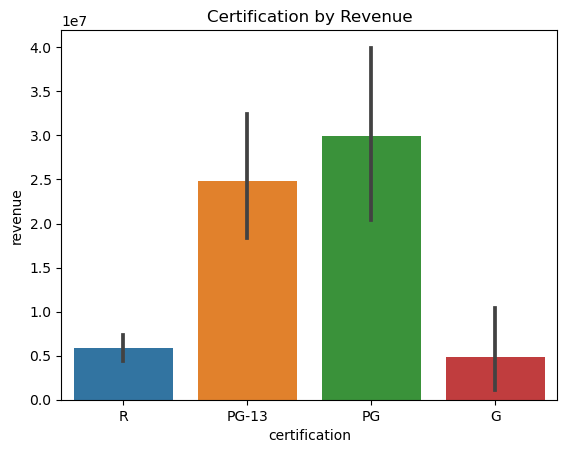

In [275]:
fig, ax = plt.subplots()

ax = sns.barplot(data=groups_df, x=groups_df['certification'], y=groups_df['revenue'])
ax.set_title('Certification by Revenue');

#### STEP 5: Pairwise Tukey Comparison Test

- Shows 4 significant results
 - 'reject' column
- Reject null hypothesis for groups:
 - 'G' and 'PG'
 - 'G' and 'PG-13'
 - 'PG' and 'R'
 - 'PG-13' and 'R'
- There is a significant difference in the results of Ratings  - 'PG' and 'PG-13' compared to the other two Ratings
- PG' and 'PG-13' return the most revenue



In [276]:
groups_df = pd.DataFrame(index=[0], data={'revenue': 0, 'certification':0})
groups_df

,revenue,certification
0,0,0


In [277]:
for i in groups:
    groups_temp = pd.DataFrame(groups[i])
    groups_temp['certification'] = i
    groups_df = pd.concat([groups_df, groups_temp])

groups_df.index.name='imdb_id'
groups_df

,revenue,certification
imdb_id,,
0,0.0,0
0,18377736.0,R
2,2078370.0,R
4,3364426.0,R
5,0.0,R
...,...,...
11843,0.0,G
12293,0.0,G
12384,0.0,G


In [278]:
groups_df.drop(index=0, inplace=True)
groups_df

,revenue,certification
imdb_id,,
2,2078370.0,R
4,3364426.0,R
5,0.0,R
7,113118226.0,R
8,0.0,R
...,...,...
11843,0.0,G
12293,0.0,G
12384,0.0,G


In [279]:
values = groups_df['revenue']
labels = groups_df['certification']

In [280]:
tukey_q1 = pairwise_tukeyhsd(values, labels)
tukey_q1.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,25001681.2797,0.0034,6291737.7538,43711624.8057,True
G,PG-13,19959868.6251,0.0203,2201687.7501,37718049.5,True
G,R,959364.1676,0.9989,-16178026.0255,18096754.3607,False
PG,PG-13,-5041812.6547,0.6447,-16105922.7973,6022297.4879,False
PG,R,-24042317.1122,0.0,-34079831.1415,-14004803.0828,True
PG-13,R,-19000504.4575,0.0,-27127169.772,-10873839.143,True


### Q2: Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?

#### STEP 1: State Null/Alternative Hypothesis
Null Hypothesis: there is no difference in earned revenue between movies that are over 2.5 hours long and movies that are 1.5 hours long (or less)

Alternative Hypothesis: there is a difference in earned revenue between movies that are over 2.5 hours long and movies that are 1.5 hours long (or less)

Alpha: 0.05

#### STEP 2: Type of Test
Datatype:
- Numeric
Number of Samples/Groups being compared
- More than 2 samples/groups:

Correct Test
if parametric:
- ANOVA and/or Tukey
if nonparametric:
- Kruskal-Wallis_ANOVA and/or Tukey

### Create 2 Groups of Data

In [281]:
# long_movie
long_movie = df_combined[df_combined['runtime'] >= 150]
long_movie

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
22,0.0,/i5W9qkiiSHxLHFOOypsCOqNeNbU.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,580430.0,ta,இஸ்பேட் ராஜாவும் இதய ராணியும்,The relationship between a grumpy guy and a pr...,3.849,/AsiChegfsDU0nfrF8vl5LfiVpw0.jpg,[],[],2019-03-15,0.0,153.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ispade Rajavum Idhaya Raniyum,0.0,6.143,7.0,NaN
46,0.0,/fdLKthr6WdIPOohnN2xK0ceA2na.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",http://shellandjoint.com/,594407.0,ja,Shell and Joint,Nitobe and Sakamoto are childhood friends who ...,1.438,/bbS5MPjkOclZvyC5Rj4A57aW511.jpg,[],"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2019-04-22,0.0,154.0,"[{'english_name': 'Finnish', 'iso_639_1': 'fi'...",Released,NaN,Shell and Joint,0.0,5.800,4.0,NaN
72,0.0,/sbD8CqLZAIWV9nbMaZebRzJ6uOH.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,606714.0,te,మన్మథుడు 2,"Under pressure to marry, a perennial bachelor ...",2.644,/fI2EKb6jnU8Knf19AocBMFfsSbB.jpg,"[{'id': 44098, 'logo_path': '/eplqXZD7BVDvu4E2...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2019-08-09,0.0,155.0,"[{'english_name': 'Telugu', 'iso_639_1': 'te',...",Released,NaN,Manmadhudu 2,0.0,6.000,7.0,NaN
94,0.0,/3gxuUj5El2TYozg7IvBXRUezFA2.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,635233.0,ml,ജാക്ക് & ഡാനിയേൽ,"Jack, a thief who hoodwinks the system and ste...",2.872,/tCad25r7nkbjLipOZMpJ1uxYWk0.jpg,"[{'id': 17568, 'logo_path': '/64HTH9aTaaXR3llq...",[],2019-11-15,0.0,156.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Jack & Daniel,0.0,3.500,10.0,NaN
114,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,697045.0,kn,Adhyaksha In America,"Ullas is a scamster living in a small town, wh...",0.908,/xBXXKv0pFrvw0fy44KAooqoMwhW.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2019-10-10,0.0,156.0,"[{'english_name': 'Kannada', 'iso_639_1': 'kn'...",Released,NaN,Adhyaksha In America,0.0,0.000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12760,0.0,/2f9YnS7JKrIqBv7dMQG8sRS2aJv.jpg,"{'id': 921781, 'name': 'Pushpa Collection', 'p...",0.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,690957.0,te,పుష్పా - The Rise,Pushpa Raj is a coolie who rises in the world ...,17.146,/r1yAzVQNbCbPTbB3GZFour9Qr0t.jpg,"[{'id': 69125, 'logo_path': '/7kRvsVRhT76VTbhG...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2021-12-16,0.0,179.0,"[{'english_name': 'Telugu', 'iso_639_1': 'te',...",Released,NaN,Pushpa: The Rise - Part 1,0.0,7.300,82.0,NaN
12784,0.0,NaN,NaN,500000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://www.redifilms.com,583631.0,hi,Tank Cleaner,A young orphan boy working as a tank cleaner i...,1.575,/rZJK2wxJfaFqwIjWPaJVao3LNT5.jpg,"[{'id': 148949, 'logo_path': None, 'name': 'Re...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2021-02-19,0.0,157.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,Suspense Thriller,Tank Cleaner,0.0,9.000,3.0,NaN
12795,0.0,/zDI8OZTmLbzNgKi060u3bk5UPV0.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}]",NaN,788106.0,kn,ಪೊಗರು,"Shiva, a ruffian, is the terror of his area in...",3.589,/iKulrSnAylrwOvXOYmJsHGTb4r1.jpg,"[{'id': 126188, 'logo_path': None, 'name': 'Sr...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2021-02-19,0.0,160.0,"[{'english_name': 'Kannada', 'iso_639_1': 'kn'...",Released,NaN,Pogaru,0.0,3.000,1.0,NaN
12802,0.0,/wfIZaLEC1scbb9VD10GotLRFKW4.jpg,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",https://www.hotstar.com/in/movies/the-big-bull...,660042.0,hi,द बिग बुल,Inspired by events from the late '80s and the ...,10.076,/j0R4hvkS5KNkChVz0UZTDkrdKzo.jpg,"[{'id': 128365, 'logo_path': '/9UnLNX7mfB1Fzie...","[{'is

In [282]:
# short movie
short_movie = df_combined[df_combined['runtime'] <= 90]
short_movie

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
9,0.0,NaN,NaN,0.0,[],NaN,792151.0,en,Paradise,Jacob and Mia Patterson had a seemingly perfec...,0.600,/gubthXDuas92hefJOn75MjozWZi.jpg,[],[],2019-04-18,0.0,0.0,[],Released,NaN,Paradise,0.0,0.000,0.0,NaN
10,0.0,/geuQqCMh8qIcIx2uPR2rdgjsZnL.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,614959.0,az,Aporia,Residents of a village are captured by an unkn...,4.010,/yMu6Qok9zobGsAHfSk1XFstzFN8.jpg,"[{'id': 174590, 'logo_path': None, 'name': 'Re...","[{'iso_3166_1': 'AZ', 'name': 'Azerbaijan'}]",2019-07-12,0.0,86.0,"[{'english_name': 'Turkish', 'iso_639_1': 'tr'...",Released,NaN,Aporia,0.0,5.600,7.0,NaN
11,0.0,/uuCj46exjP6UOo976MAWACWFv1X.jpg,"{'id': 526203, 'name': 'A Christmas Prince Col...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 1075...",https://www.netflix.com/title/81029841,587693.0,en,A Christmas Prince: The Royal Baby,Christmas brings the ultimate gift to Aldovia:...,14.926,/4RErLw0APt8qQiee0d8VCKasWwl.jpg,"[{'id': 2090, 'logo_path': '/jYlUttNqcN5u1pzMQ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-12-05,0.0,84.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Baby Makes 3,A Christmas Prince: The Royal Baby,0.0,6.309,488.0,NaN
12,0.0,/gfIUztE4nhnt9rawDn49juZOj3j.jpg,NaN,2600000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,622124.0,da,Jagtsæson,"Eva, a recently divorced, single mom, goes awa...",1.167,/nv3RnXWFp4du3GoT2bPlWZlP4JH.jpg,"[{'id': 235, 'logo_path': '/obOynoztBEhDNfHsDX...",[],2019-10-03,0.0,90.0,"[{'english_name': 'Danish', 'iso_639_1': 'da',...",Released,NaN,Hunting Season,0.0,4.100,8.0,NaN
15,0.0,/r2cQUkSZOKEUrbQ0sXgSz7H7CCp.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://familyobligationsfilm.com/,618008.0,en,Family Obligations,One man learns to die. Another man learns to l...,2.336,/rYibqUDuG35vaJQqjGQSwDQevNq.jpg,"[{'id': 126417, 'logo_path': None, 'name': 'In...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-06-06,0.0,81.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,One man learns to die. Another man learns to l...,Family Obligations,0.0,10.000,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12875,0.0,/iVAZeGHmnV8JdjxMhEwAvetySwf.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,729793.0,de,Ein nasser Hund,"Based on a provocative autobiography, this sto...",1.399,/BJyDGHUFsKKEL7tmyoqPcs0cMk.jpg,"[{'id': 132346, 'logo_path': None, 'name': 'Ca...","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",2021-09-09,0.0,0.0,[],Released,NaN,Wet Dog,0.0,6.900,7.0,NaN
12876,0.0,/7sLtpZZb3ErdHxmtUKIkmuuEtcR.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,688616.0,it,Resurrection Corporation,Caligari is a famous undertaker who’s been on ...,0.600,/nyos6rWiap3uLGqZYomhFL3PaoT.jpg,"[{'id': 131490, 'logo_path': None, 'name': 'Lo...","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2021-09-17,0.0,0.0,"[{'english_name': 'Italian', 'iso_639_1': 'it'...",Released,The Reaper has never been cheaper,Resurrection Corporation,0.0,6.900,5.0,NaN
12877,0.0,NaN,"{'id': 977876, 'name': 'The Tribunal Collectio...",0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,788854.0,en,Divine Decision: Double Down,The seven-year-itch hits the marriage of Joe a...,0.977,/9zFhX7kIiLfSH6M20cDXcmfDg5S.jpg,"[{'id': 128286, 'logo_path': None, 'name': 'St...","[{'iso_3166_1': 'US', 'name': 'United States o...",2020-09-04,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Their love still depends on it.,Divine Decision: Double Down,0.0,4.000,4.0,NaN
12879,0.0,/e5XIgJd98MZEZTz6VhxpiG10BhG.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",http://italianstudiesfilm.com,662399.0,en,Italian Studies,A mysterious woma

In [283]:
long_revenue = long_movie['revenue']
short_revenue = short_movie['revenue']

#### STEP 3: Assumptions

- No significant outliers
- Normality
- Equal Variance

### Outliers

In [284]:
# long revenue
zscores_long = stats.zscore(long_revenue)
outliers_long = abs(zscores_long)>3
print(f'Len: {len(long_revenue)}')
print(f'Number of Ouliers: {np.sum(outliers_long)}')

long_revenue = long_revenue[~outliers_long]
print(f'Len: {len(long_revenue)}')

Len: 290
Number of Ouliers: 3
Len: 287


In [285]:
# short revenue
zscores_short = stats.zscore(short_revenue)
outliers_short = abs(zscores_short)>3
print(f'Len: {len(short_revenue)}')
print(f'Number of Ouliers: {np.sum(outliers_short)}')

short_revenue = short_revenue[~outliers_short]
print(f'Len: {len(short_revenue)}')

Len: 5573
Number of Ouliers: 23
Len: 5550


### Normality
- Since both groups have sample count >15, we can skip this step entirely.

### Equal Variance
- Equal Variance assumption is not met
- Will add equal_var=False argument to test

In [286]:
stats.levene(long_revenue, short_revenue)

LeveneResult(statistic=234.09332293531463, pvalue=7.663222407017023e-52)

#### STEP 4: Perform Test & Interpret Result

- p-value < 0.05 (alpha), reject Null Hypothesis and support Alternative Hypothesis

- Runtime length does affect revenue

In [287]:
result_q2 = stats.ttest_ind(long_revenue, short_revenue, equal_var=False)
result_q2

Ttest_indResult(statistic=3.4759210493854464, pvalue=0.0005881241616916527)

In [288]:
## is our result significant
print(f"p-value={result_q2.pvalue:.10f}")
print(f"Significant: {result_q2.pvalue <.05}")

p-value=0.0005881242
Significant: True


### Visualization

In [289]:
long_revenue_df = pd.DataFrame(long_revenue)
long_revenue_df['runtime'] = 'long'
long_revenue_df

,revenue,runtime
22,0.0,long
46,0.0,long
72,0.0,long
94,0.0,long
114,0.0,long
...,...,...
12760,0.0,long
12784,0.0,long
12795,0.0,long
12802,0.0,long


In [330]:
short_revenue_df = pd.DataFrame(short_revenue)
short_revenue_df['runtime'] = 'short'
short_revenue_df

,revenue,runtime
9,0.0,short
10,0.0,short
11,0.0,short
12,0.0,short
15,0.0,short
...,...,...
12875,0.0,short
12876,0.0,short
12877,0.0,short
12879,0.0,short


In [331]:
plot_q2 = pd.concat([long_revenue_df, short_revenue_df])
plot_q2

,revenue,runtime
22,0.0,long
46,0.0,long
72,0.0,long
94,0.0,long
114,0.0,long
...,...,...
12875,0.0,short
12876,0.0,short
12877,0.0,short
12879,0.0,short


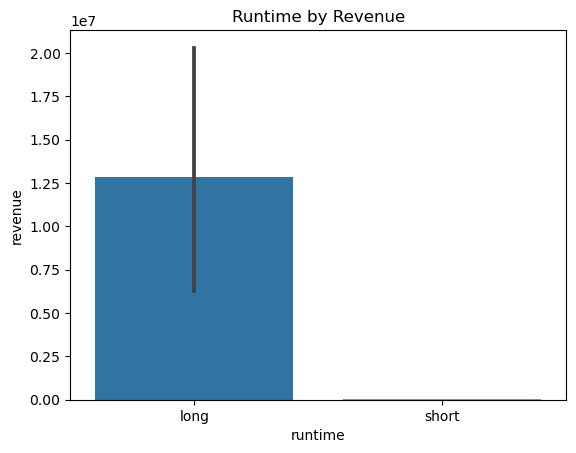

In [332]:
fig, ax = plt.subplots()

ax = sns.barplot(data=plot_q2, x='runtime', y='revenue')
ax.set_title('Runtime by Revenue');

### Q3: Do some movie genres earn more revenue than others?

### Clean Data

In [333]:
df_q3 = df_combined.copy()

In [334]:
df_q3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12886 entries, 0 to 12885
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  12886 non-null  float64
 1   backdrop_path          10027 non-null  object 
 2   belongs_to_collection  733 non-null    object 
 3   budget                 12886 non-null  float64
 4   genres                 12886 non-null  object 
 5   homepage               3527 non-null   object 
 6   id                     12886 non-null  float64
 7   original_language      12886 non-null  object 
 8   original_title         12886 non-null  object 
 9   overview               12686 non-null  object 
 10  popularity             12886 non-null  float64
 11  poster_path            12641 non-null  object 
 12  production_companies   12886 non-null  object 
 13  production_countries   12886 non-null  object 
 14  release_date           12638 non-null  object 
 15  re

In [335]:
print(type(df_q3['genres'][0]))
print(df_q3['genres'][0])

<class 'str'>
[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}]


In [336]:
## use .str.replace to replace all single quotes
df_q3['genres'] = df_q3['genres'].str.replace("'",'"')
## Apply the json.loads to the full column
df_q3['genres'] = df_q3['genres'].apply(json.loads)

In [337]:
print(type(df_q3['genres'][0]))
print(df_q3['genres'][0])

<class 'list'>
[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}]


In [338]:
type(df_q3['genres'][0][0])

dict

In [339]:
df_q3 = df_q3[df_q3['genres'].map(lambda d: len(d)) > 0]
df_q3

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0.0,/xMHeU84wLQ9uH9acJ0oPgdii9wO.jpg,NaN,26000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",https://www.motherlessbrooklynfilm.com,504562.0,en,Motherless Brooklyn,"New York City, 1957. Lionel Essrog, a private ...",17.088,/jjMJy5OxJHpFIaboCklDIYdcfpD.jpg,"[{'id': 2297, 'logo_path': None, 'name': 'Clas...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-10-31,18377736.0,145.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Motherless Brooklyn,0.0,6.722,1285.0,R
1,0.0,/8RKBHHRqOMOLh5qW3sS6TSFTd8h.jpg,NaN,170000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",https://family.20thcenturystudios.com/movies/a...,399579.0,en,Alita: Battle Angel,When Alita awakens with no memory of who she i...,59.132,/xRWht48C2V8XNfzvPehyClOvDni.jpg,"[{'id': 10807, 'logo_path': '/j0BcMaJKIiDDYHq9...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-01-31,404980543.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,An angel falls. A warrior rises.,Alita: Battle Angel,0.0,7.217,8316.0,PG-13
2,0.0,/7uacpbrJd9g9xSTLgfyg1NwkAiu.jpg,NaN,23934823.0,"[{'id': 10752, 'name': 'War'}, {'id': 28, 'nam...",http://dangerclosemovie.com,508664.0,en,Danger Close: The Battle of Long Tan,"Vietnam War, 1966. Australia and New Zealand s...",19.663,/aB1rCWGMsM2mm1kBDleaPkqUCFo.jpg,"[{'id': 101576, 'logo_path': None, 'name': 'Re...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...",2019-08-08,2078370.0,119.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Outnumbered. Outgunned. Never out of courage,Danger Close: The Battle of Long Tan,0.0,6.872,270.0,R
3,0.0,/o7JVhqMmrex1TPbmuxl8YXVlcfl.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",80000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",http://www.shazammovie.com,287947.0,en,Shazam!,A boy is given the ability to become an adult ...,62.795,/xnopI5Xtky18MPhK40cZAGAOVeV.jpg,"[{'id': 12, 'logo_path': '/5ThIuO93vsk47oexKTS...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-03-29,366080049.0,132.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Just say the word.,Shazam!,0.0,7.000,8697.0,PG-13
4,0.0,/eZwwJ5yRpMDhZzfMS7XeWwUzLSE.jpg,NaN,20000000.0,"[{'id': 10752, 'name': 'War'}, {'id': 18, 'nam...",https://www.thelastfullmeasurefilm.com/,442065.0,en,The Last Full Measure,The incredible true story of Vietnam War hero ...,14.652,/bMG8c80lyEkBXVgyHVqsdQhjgf6.jpg,"[{'id': 21897, 'logo_path': None, 'name': 'For...","[{'iso_3166_1': 'US', 'name': 'United States o...",2020-01-23,3364426.0,110.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate sacrifice deserves the highest ho...,The Last Full Measure,0.0,7.472,394.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12881,0.0,/S1kutYyoyuBJKGS0mXxv2fZNbr.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,834443.0,de,Heikos Welt,A son tries to save his mother's eyesight by d...,1.590,/u2rxIUdUoCkm8gDfYPnFEHS4OLp.jpg,"[{'id': 154995, 'logo_path': None, 'name': 'AS...","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",2021-09-08,0.0,118.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Heiko's World,0.0,6.375,4.0,NaN
12882,0.0,/hMvRbT6HOqERhh3K8kXbaLz9LlZ.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,821493.0,en,India Sweets and Spices,A college freshman confronts her parents’ valu...,3.074,/2cUczTzLq1F99Pgiw6BWFsKnD7J.jpg,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...","[{'iso_3166_1': 'US', 'name': 'United States o...",2021-11-19,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Let the aunties talk.,India Sweets and Spices,0.0,

In [340]:
exploded = df_q3.explode('genres')
exploded_unpack = exploded['genres'].apply(pd.Series)

In [341]:
cols_to_make = exploded_unpack['name'].dropna().unique()
cols_to_make

array(['Drama', 'Thriller', 'Action', 'Science Fiction', 'Adventure',
       'War', 'History', 'Comedy', 'Fantasy', 'Music', 'Romance',
       'Horror', 'Family', 'Crime', 'Mystery', 'TV Movie', 'Western',
       'Documentary', 'Animation'], dtype=object)

In [342]:
pd.set_option('display.max_columns', None)

In [343]:
for col in cols_to_make:
    df_q3[col] = df_q3['genres'].str.contains(col)
df_q3.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,Drama,Thriller,Action,Science Fiction,Adventure,War,History,Comedy,Fantasy,Music,Romance,Horror,Family,Crime,Mystery,TV Movie,Western,Documentary,Animation
0,0.0,/xMHeU84wLQ9uH9acJ0oPgdii9wO.jpg,NaN,26000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",https://www.motherlessbrooklynfilm.com,504562.0,en,Motherless Brooklyn,"New York City, 1957. Lionel Essrog, a private ...",17.088,/jjMJy5OxJHpFIaboCklDIYdcfpD.jpg,"[{'id': 2297, 'logo_path': None, 'name': 'Clas...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-10-31,18377736.0,145.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Motherless Brooklyn,0.0,6.722,1285.0,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,/8RKBHHRqOMOLh5qW3sS6TSFTd8h.jpg,NaN,170000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",https://family.20thcenturystudios.com/movies/a...,399579.0,en,Alita: Battle Angel,When Alita awakens with no memory of who she i...,59.132,/xRWht48C2V8XNfzvPehyClOvDni.jpg,"[{'id': 10807, 'logo_path': '/j0BcMaJKIiDDYHq9...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-01-31,404980543.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,An angel falls. A warrior rises.,Alita: Battle Angel,0.0,7.217,8316.0,PG-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,/7uacpbrJd9g9xSTLgfyg1NwkAiu.jpg,NaN,23934823.0,"[{'id': 10752, 'name': 'War'}, {'id': 28, 'nam...",http://dangerclosemovie.com,508664.0,en,Danger Close: The Battle of Long Tan,"Vietnam War, 1966. Australia and New Zealand s...",19.663,/aB1rCWGMsM2mm1kBDleaPkqUCFo.jpg,"[{'id': 101576, 'logo_path': None, 'name': 'Re...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...",2019-08-08,2078370.0,119.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Outnumbered. Outgunned. Never out of courage,Danger Close: The Battle of Long Tan,0.0,6.872,270.0,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,/o7JVhqMmrex1TPbmuxl8YXVlcfl.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",80000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",http://www.shazammovie.com,287947.0,en,Shazam!,A boy is given the ability to become an adult ...,62.795,/xnopI5Xtky18MPhK40cZAGAOVeV.jpg,"[{'id': 12, 'logo_path': '/5ThIuO93vsk47oexKTS...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-03-29,366080049.0,132.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Just say the word.,Shazam!,0.0,7.000,8697.0,PG-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,/eZwwJ5yRpMDhZzfMS7XeWwUzLSE.jpg,NaN,20000000.0,"[{'id': 10752, 'name': 'War'}, {'id': 18, 'nam...",https://www.thelastfullmeasurefilm.com/,442065.0,en,The Last Full Measure,The incredible true story of Vietnam War hero ...,14.652,/bMG8c80lyEkBXVgyHVqsdQhjgf6.jpg,"[{'id': 21897, 'logo_path': None, 'name': 'For...","[{'iso_3166_1': 'US', 'name': 'United States o...",2020-01-23,3364426.0,110.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate sacrifice deserves the highest ho...,The Last Full Measure,0.0,7.472,394.0,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### STEP 1: State Null/Alternative Hypothesis

Null Hypothesis: there is no difference in earned revenue between movie genres

Alternative Hypothesis: there is a difference in earned revenue between movie genres

Alpha: 0.05

### STEP 2: Type of Test

ANOVA:
Comparing numeric data: revenue

More than 2 groups: 19 total

In [344]:
len(cols_to_make)

19

### STEP 3: Assumptions

No significant outliers

Normality

Equal Variance

### Outliers

In [345]:
for i in groups_q3:
    print(f'{i} - Number of rows: {len(groups_q3[i])}')
    z_score = stats.zscore(groups_q3[i])
    outliers = abs(z_score)>3
    print(f'{i} - Number of outliers: {np.sum(outliers)}')
    
    groups_q3[i] = groups_q3[i][~outliers]
    print(f'{i} - Number of rows: {len(groups_q3[i])}')
    print('')

### Normality

All group sample sizes are > 20

Can skip this step entirely

### Equal Variance

Does not meet assumption of equal variance; p < 0.05

Will continue with a Kruskal-Wallis test

### STEP 4: Perform Test & Interpret Results

Kruskal-Wallis Test

Reject null hypothesis and support Alternative Hypothesis


p-value < 0.05

There is a difference in revenue between movie genres

In [365]:
groups_q3_df = pd.DataFrame(index=[0], data={'revenue': 0, 'genres':0})
groups_q3_df

,revenue,genres
0,0,0


In [366]:
for i in groups_q3:
    groups_q3_temp = pd.DataFrame(groups_q3[i])
    groups_q3_temp['genres'] = i
    groups_q3_df = pd.concat([groups_q3_df, groups_q3_temp])

groups_q3_df.index.name='imdb_id'
groups_q3_df

,revenue,genres
imdb_id,,
0,0,0


In [367]:
groups_q3_df.drop(index=0, inplace=True)
groups_q3_df

,revenue,genres
imdb_id,,


In [368]:
df_agg = groups_q3_df.groupby('genres')['revenue'].mean().sort_values(ascending=False)
df_agg

Series([], Name: revenue, dtype: float64)

### STEP 5: Pairwise Tukey Comparison Test

- According to the Tukey Comparison Test and the barplot above, we can see that 'Adventure' genre has the most significant difference
- In total, there were 86 significant pairs

In [370]:
values_q3 = groups_q3_df['revenue']
labels_q3 = groups_q3_df['genres']

In [371]:
tukey_q3 = pairwise_tukeyhsd(values_q3, labels_q3)
tukey_q3.summary()

ValueError: 2 or more groups required for multiple comparisons

In [372]:
tukey_df = pd.DataFrame(tukey_q3.summary().data )
tukey_df

NameError: name 'tukey_q3' is not defined

In [373]:
tukey_df.columns = tukey_df.iloc[0]
tukey_df.columns

NameError: name 'tukey_df' is not defined

In [374]:
tukey_df.drop(index=0, inplace=True)
tukey_df

NameError: name 'tukey_df' is not defined

#### Tukey DataFrame 'reject' == True

In [ ]:
tukey_df_true = tukey_df[tukey_df['reject'] == True]
tukey_df_true

In [ ]:
tukey_df_true['group1'].value_counts()

### Visualization

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(8,4), facecolor='w')
plt.title('Movie Genres', fontsize = 22, weight='bold')
ax = sns.barplot(data=tukeys_data, x='genre_name', y='revenue', ci=68, palette="copper")
ax.set_xticklabels(ax.get_xticklabels(), rotation='45', ha='right')
plt.xlabel("Genre", fontsize = 16, weight='bold')
plt.xticks(weight='bold')
ax.set_ylabel('Revenue (dollars)',fontweight='bold',fontsize=14)
ax.set_facecolor('gray')
ax.tick_params(labelcolor='k', labelsize=10)
ax.set_yticklabels(ax.get_yticks(), weight='bold')
ax.yaxis.set_major_formatter(price_fmt)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.tight_layout()
plt.show;

## Summary and Reccomendations

### Summary of the hypotheses tests

- The MPAA rating of a movie does affect how much revenue the movie generates.
 - Movies that have an MPAA Rating of PG make the most revenue.
- The genre of a movie does affect how much revenue a movie generates.
 - Adventure, Sci-fi, and Action movie genres, in descending order generate the greatest revenue.
- Movies that are over 2.5 hours have a significantly different revenue than movies that under 1.5 hours in length.

### Recommendations

In order to maximize revenue for a movie, it would be recommended to produce:
 - a PG rated, adventure movie with a runtime greater than 2.5 hours.